In [ ]:
! pip install osmnx jupyter sumo-user-libs selenium webdriver-manager

In [ ]:
! sudo apt install netconvert

Unsimplified graph successfully saved as map.osm.xml


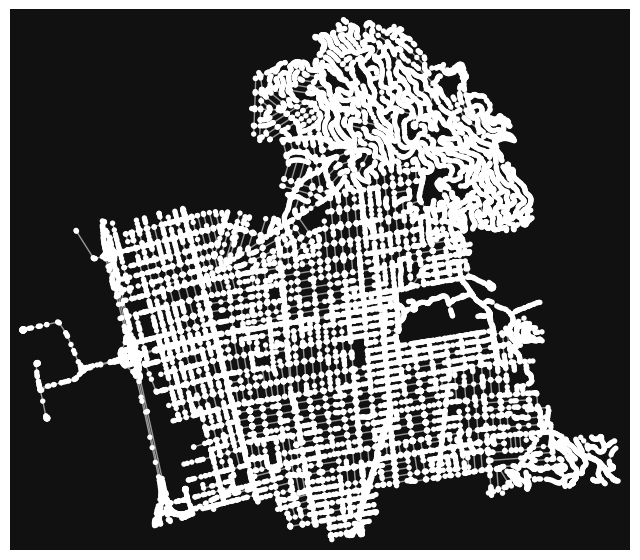

In [12]:
import osmnx as ox
import matplotlib.pyplot as plt

ox.settings.all_oneway = True

# Let's try a different, well-known area.
place_name = "Berkeley, California, USA"

graph_unsimplified = ox.graph_from_place(place_name, network_type='drive', simplify=False)

ox.save_graph_xml(graph_unsimplified, filepath="./map.osm.xml")
print("Unsimplified graph successfully saved as map.osm.xml")


fig, ax = ox.plot_graph(graph_unsimplified)
plt.show()

In [13]:
! netconvert --osm-files map.osm.xml -o map.net.xml

Success.


In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import time

# --- Setup Selenium WebDriver ---
# To run headlessly (without a visible browser window), uncomment the next two lines
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox') # Required for running as root/in containers
options.add_argument('--disable-dev-shm-usage') # Overcome limited resource problems

service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# --- Define two points (using coordinates from your OSMnx graph) ---
origin_lat, origin_lon = 37.8716, -122.2727 # Downtown Berkeley
destination_lat, destination_lon = 37.8272, -122.2901 # A point in West Berkeley

# --- Construct the Google Maps URL and navigate to it ---
# We add '&mode=d' to explicitly ask for driving directions
url = f"https://www.google.com/maps/dir/{origin_lat},{origin_lon}/{destination_lat},{destination_lon}/?mode=d"
print(f"Navigating to: {url}")
driver.get(url)

# --- Scrape the Data ---
try:
    # Google Maps often asks for cookie consent. We need to click "Reject all" or "Accept all".
    # Using a more general XPath to find any button with "Reject" or "Accept" text.
    consent_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, '//button[contains(., "Reject") or contains(., "Accept")]'))
    )
    consent_button.click()
    print("Handled cookie consent.")
except Exception as e:
    print("Cookie consent banner not found or could not be clicked. Continuing...")

try:
    # --- NEW, MORE ROBUST SELECTOR ---
    # This XPath looks for the main trip duration. It finds the element that shows the
    # driving time for the first (usually best) route.
    # It looks for a div with a specific data attribute often used for the travel icon.
    travel_time_xpath = '//div[@data-travel_mode="0"]//div[contains(@class, "duration")]'
    
    travel_time_element = WebDriverWait(driver, 15).until(
        EC.presence_of_element_located((By.XPATH, travel_time_xpath))
    )
    
    travel_time = travel_time_element.text
    print(f"Successfully Scraped Travel Time: {travel_time}")

except Exception as e:
    print(f"Could not extract travel time. Error: {e}")
    # Save a screenshot and the page source to debug what the page looked like
    driver.save_screenshot("debug_screenshot.png")
    with open("debug_page_source.html", "w", encoding="utf-8") as f:
        f.write(driver.page_source)
    print("Saved debug_screenshot.png and debug_page_source.html for analysis.")

finally:
    # Close the browser
    driver.quit()

Navigating to: https://www.google.com/maps/dir/37.8716,-122.2727/37.8272,-122.2901/?mode=d
